In [1]:
#from google.colab import drive

In [2]:
#drive.mount('/content/drive')

In [3]:
#import os
#os.chdir("/content/drive")

In [4]:
#cd My Drive

In [5]:
#cd CS230-master

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import time
%matplotlib inline
# 
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

In [7]:
import os; 
#work-around to allow import from directory on same level
os.sys.path.append(os.path.dirname(os.path.abspath('.')))
from input.DataLoader import DataLoader
from input.GenerateBatch import GenerateBatch
from model.Model3 import train_generator

Using TensorFlow backend.


In [8]:
from sklearn.preprocessing import MinMaxScaler
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense,Dropout,Activation, Lambda
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten
from keras.layers import  MaxPooling1D, MaxPooling2D,Reshape, BatchNormalization
from keras.utils import to_categorical
from keras.metrics import categorical_crossentropy
from scipy.stats import linregress
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
from keras.backend import transpose, permute_dimensions,squeeze
from keras.optimizers import Adam

In [9]:
# PARAMETERS AND COMMENTs
#
# Conv2D with 10bar target and 0-5.6-7 training/val 
# standardize window = false
# Dropout back to 50; epochs back to 60
# Try l2 reg on dense layer with small batch size - 50
configs={}
configs['batch_size']=50

configs['sequence_length']=100
configs['epochs']=100
configs['learning_rate']=.001
configs['learning_rate_decay']=0
configs['opt']=Adam(lr=configs['learning_rate'],
                   decay=configs['learning_rate_decay'])
configs['save_dir']='saved_models'
configs['nflag']=False #standardize each window



traindays=[0,1,2,3,4,5,6,7] #training and val days to look at in dataset
valdays=[8,9]
colx=range(40)# columns to look at in dataset - 0-40 are LOB
#colx=np.concatenate([np.arange(20),86+np.arange(20)])
coly=148 # target 144-148 are 1,2,3,5,10
generate_files=True
print('trainday',traindays,'valdays',valdays,'colx',colx,'coly',coly)
print(configs)

trainday [0, 1, 2, 3, 4, 5, 6, 7] valdays [8, 9] colx range(0, 40) coly 148
{'batch_size': 50, 'sequence_length': 100, 'epochs': 100, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'opt': <keras.optimizers.Adam object at 0x7f115b872fd0>, 'save_dir': 'saved_models', 'nflag': False}


### Generate data from zip files or retrieve from pkl files in directory

In [10]:
if generate_files==True:
  path='data/'
  d=DataLoader(path)
  traindf=d.get_days(traindays)
  trainoffset=d.get_stock_offset(traindays)
  valdf=d.get_days(valdays)
  valoffset=d.get_stock_offset(valdays)

  traindf.to_pickle("traindf.pkl")
  valdf.to_pickle("valdf.pkl")
  np.save("trainoffset",trainoffset)
  np.save("valoffset",valoffset)

else:
  traindf=pd.read_pickle('traindf.pkl')
  valdf=pd.read_pickle('valdf.pkl')
  trainoffset=np.load("trainoffset.npy")
  valoffset=np.load("valoffset.npy")

# Select X and Y training and dev data. Y is categorical
trainx=traindf.iloc[:,colx].values
trainy=to_categorical(traindf.iloc[:,coly].values-1)
valx=valdf.iloc[:,colx].values
valy=to_categorical(valdf.iloc[:,coly].values-1)



### Build and compile model

In [11]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(4, 40), strides=(1, 1),data_format='channels_last',activation='relu',
                 input_shape=(configs['sequence_length'],len(colx),1)))
model.add(Conv2D(16, kernel_size=(1,1),strides=(1,1),data_format='channels_last',activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,1), strides=2))
model.add(Conv2D(32,kernel_size=(4,1), strides=(1,1),data_format='channels_last',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,1), strides=2))
model.add(Conv2D(32,kernel_size=(3,1), strides=(1,1),data_format='channels_last',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,1), strides=2))
model.add(Flatten())
#model.add(Dense(100,activation='relu'))
model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation='relu'))
#model.add(BatchNormalization(momentum=0.9))
model.add(Dropout(0.50))
#model.add(Dense(64,kernel_regularizer=regularizers.l2(0.01),activation='relu'))
#model.add(Dropout(0.20))
model.add(Dense(3, activation='softmax'))
#
opt=Adam(lr=configs['learning_rate'],decay=configs['learning_rate_decay'])
model.compile(loss="categorical_crossentropy", optimizer=configs['opt'],metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 97, 1, 16)         2576      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 1, 16)         272       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 1, 32)         2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 1, 32)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 1, 32)         3104      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 1, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 704)               0         
__________

### Model Fitting

In [12]:
training_generator=GenerateBatch(trainx,trainy,trainoffset)
val_generator=GenerateBatch(valx,valy,valoffset)

In [13]:
# out-of memory generative training
steps_per_epoch=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])
steps_per_epoch_val=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])

In [14]:
# GenerateBatch2 contains logic to avoid running over stock/day divides
history=train_generator(
    model=model,
    train_gen=training_generator.GenerateBatch_conv(configs['sequence_length'],
                                               configs['batch_size'],
                                               configs['nflag']),
    val_gen=val_generator.GenerateBatch_conv(configs['sequence_length'],
                                        configs['batch_size'],
                                        configs['nflag']),
    epochs=configs['epochs'],
    batch_size=configs['batch_size'],
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch_val,
    save_dir=configs['save_dir']
    )

    

[Model] Training Started
[Model] 100 epochs, 50 batch size, 6146.0 batches per epoch
Epoch 1/100
 - 49s - loss: 1.0571 - acc: 0.4063 - val_loss: 1.1167 - val_acc: 0.3176
Epoch 2/100
 - 46s - loss: 1.0479 - acc: 0.4091 - val_loss: 1.1515 - val_acc: 0.3162
Epoch 3/100
 - 46s - loss: 1.0525 - acc: 0.3996 - val_loss: 1.1065 - val_acc: 0.3120
Epoch 4/100
 - 46s - loss: 1.0470 - acc: 0.4081 - val_loss: 1.1121 - val_acc: 0.3488
Epoch 5/100
 - 46s - loss: 1.0462 - acc: 0.4108 - val_loss: 1.1360 - val_acc: 0.3438
Epoch 6/100
 - 46s - loss: 1.0509 - acc: 0.4051 - val_loss: 1.0996 - val_acc: 0.3544
Epoch 7/100
 - 45s - loss: 1.0484 - acc: 0.4071 - val_loss: 1.1133 - val_acc: 0.3193
Epoch 8/100
 - 46s - loss: 1.0504 - acc: 0.4048 - val_loss: 1.1135 - val_acc: 0.3197
Epoch 9/100
 - 46s - loss: 1.0486 - acc: 0.4030 - val_loss: 1.1047 - val_acc: 0.3110
Epoch 10/100
 - 46s - loss: 1.0485 - acc: 0.4051 - val_loss: 1.1108 - val_acc: 0.3197
Epoch 11/100
 - 46s - loss: 1.0487 - acc: 0.4042 - val_loss: 1.1

Epoch 96/100
 - 48s - loss: 0.8880 - acc: 0.5923 - val_loss: 1.0111 - val_acc: 0.4942
Epoch 97/100
 - 48s - loss: 0.8881 - acc: 0.5926 - val_loss: 0.8917 - val_acc: 0.5998
Epoch 98/100
 - 48s - loss: 0.8856 - acc: 0.5956 - val_loss: 0.9728 - val_acc: 0.5222
Epoch 99/100
 - 48s - loss: 0.8863 - acc: 0.5959 - val_loss: 0.9314 - val_acc: 0.5584
Epoch 100/100
 - 48s - loss: 0.8832 - acc: 0.5978 - val_loss: 0.8753 - val_acc: 0.6158
[Model] Training Completed. Model saved as saved_models/07122018-155036-e100.h5
Time taken: 1:17:43.475959


In [15]:
#from keras.models import load_model
#model = load_model('saved_models/04122018-125307-e20.h5')

Text(0,0.5,'Cost')

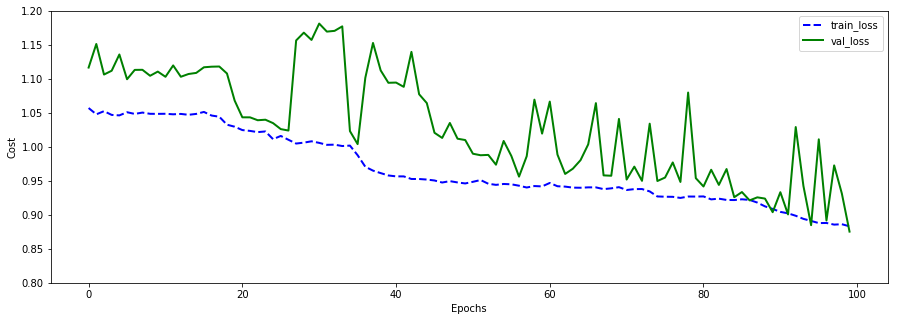

In [44]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
plt.legend()
plt.ylim([.8,1.2])
plt.xlabel('Epochs')
plt.ylabel('Cost')

In [17]:
# make our predictions - start from beginning
train_gen=training_generator.GenerateBatch_conv(configs['sequence_length'],configs['batch_size'],configs['nflag'])
val_gen=val_generator.GenerateBatch_conv(configs['sequence_length'],configs['batch_size'],configs['nflag'])

In [18]:
y_train=[]
yhat_train=[]
y_val=[]
yhat_val=[]

In [19]:
# predict using same sequence lengths and batches as in training
for i in range(int(steps_per_epoch)):
    dat=next(train_gen)
    y_train.append(dat[1])
    yhat_train.append(model.predict(dat[0]))
for i in range(int(steps_per_epoch_val)):
    dat=next(val_gen)
    y_val.append(dat[1])
    yhat_val.append(model.predict(dat[0]))
                                            

In [20]:
burn_in=0 # drop early predictions 
y_train=np.concatenate(y_train).reshape(-1,3)[burn_in:]
yhat_train=np.concatenate(yhat_train).reshape(-1,3)[burn_in:]
y_val=np.concatenate(y_val).reshape(-1,3)[burn_in:]
yhat_val=np.concatenate(yhat_val).reshape(-1,3)[burn_in:]


### Training and Validation Performance

In [21]:
# How well have we done on training data
print ("Training ")
Y=np.argmax(y_train,axis=1)
Yhat=np.argmax(yhat_train,axis=1)
c=confusion_matrix(Y,Yhat)
c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
#print(c)
print(classification_report(Yhat,Y))
print("cohen kappa score: %.2f" %cohen_kappa_score(Yhat,Y))
# How well have we done on test data
print("Test ")
Y=np.argmax(y_val,axis=1)
Yhat=np.argmax(yhat_val,axis=1)
c=confusion_matrix(Y,Yhat)
c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
#print(c)
print(classification_report(Yhat,Y))
print("cohen kappa score: %.2f" % cohen_kappa_score(Yhat,Y))

Training 
             precision    recall  f1-score   support

          0       0.67      0.58      0.62    137603
          1       0.67      0.64      0.65     73309
          2       0.53      0.65      0.59     95356

avg / total       0.63      0.62      0.62    306268

cohen kappa score: 0.41
Test 
             precision    recall  f1-score   support

          0       0.66      0.55      0.60    129879
          1       0.66      0.71      0.68     91262
          2       0.52      0.62      0.57     85332

avg / total       0.62      0.62      0.62    306473

cohen kappa score: 0.42


### Visualize Filters using Gradient Ascent

In [22]:
import keras.backend as K

In [23]:
layer_dict=dict([(layer.name,layer) for layer in model.layers[1::]])
input_img=model.input

In [24]:
def normalize(x):
     return x/(K.sqrt(K.mean(K.square(x)))+K.epsilon())

In [25]:
layer_name='conv2d_4'
n=64

In [26]:
kept_filters=[]
for filter_index in range(n):
    layer_output=layer_dict[layer_name].output
    loss=K.mean(layer_output[:,filter_index:,:])
    grads=K.gradients(loss,input_img)[0]
    grads=normalize(grads)
    iterate=K.function([input_img],[loss,grads])
    step=1
    input_img_data=np.random.random((1,100,40,1))
    for i in range(40):
        loss_value,grad_values=iterate([input_img_data])
        input_img_data +=grad_values*step
    print('Filter: %d, Final loss value:%.2f' % (filter_index,loss_value))
    if loss_value >0:
        kept_filters.append((input_img_data[0],loss_value))
print(len(kept_filters))

Filter: 0, Final loss value:93.54
Filter: 1, Final loss value:73.74
Filter: 2, Final loss value:79.61
Filter: 3, Final loss value:76.80
Filter: 4, Final loss value:80.54
Filter: 5, Final loss value:71.05
Filter: 6, Final loss value:77.20
Filter: 7, Final loss value:80.33
Filter: 8, Final loss value:89.63
Filter: 9, Final loss value:88.36
Filter: 10, Final loss value:99.77
Filter: 11, Final loss value:88.49
Filter: 12, Final loss value:97.56
Filter: 13, Final loss value:82.76
Filter: 14, Final loss value:114.45
Filter: 15, Final loss value:90.77
Filter: 16, Final loss value:103.08
Filter: 17, Final loss value:94.98
Filter: 18, Final loss value:104.30
Filter: 19, Final loss value:119.07
Filter: 20, Final loss value:101.81
Filter: 21, Final loss value:103.44
Filter: 22, Final loss value:105.83
Filter: 23, Final loss value:107.74
Filter: 24, Final loss value:145.92
Filter: 25, Final loss value:121.57
Filter: 26, Final loss value:96.70
Filter: 27, Final loss value:166.07
Filter: 28, Final l

In [27]:
len(kept_filters)

45

In [28]:
f0=kept_filters[0]

In [29]:
f0[1]

93.53719

In [30]:
f0[0].shape

(100, 40, 1)

In [31]:
img=f0[0]

In [32]:
img.shape

(100, 40, 1)

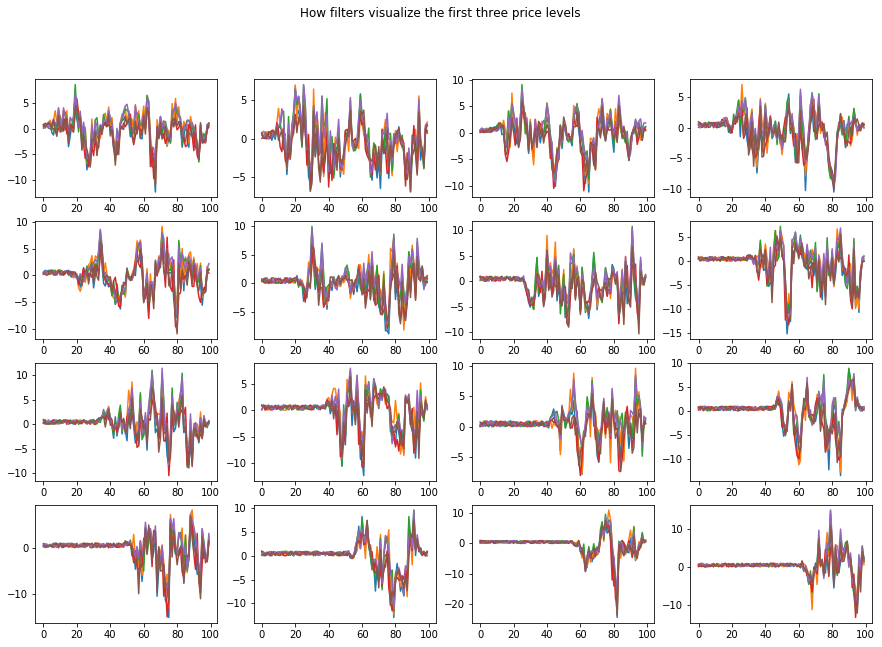

In [56]:
plt.figure(figsize=(15,10))
plt.suptitle("How filters visualize the first three price levels",fontsize=12)
k=[kept_filters[i] for i in 2*np.arange(16)]
for i,f in enumerate(k):
    img=f[0][:,:,0]
    plt.subplot(4,4,i+1)
    plt.plot(img[range(0,100)][:,[0,2,4,6,8,10]])


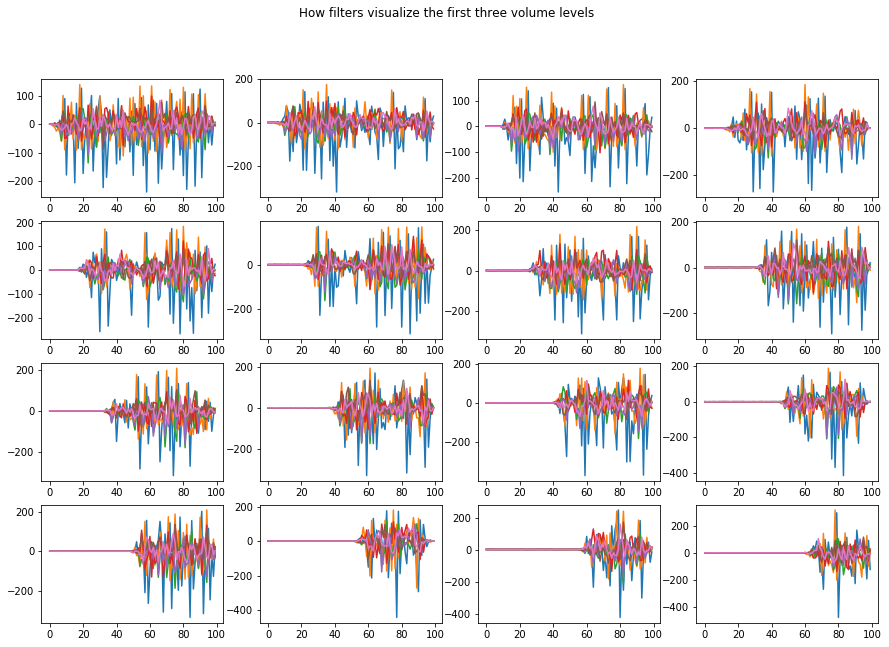

In [57]:
plt.figure(figsize=(15,10))
plt.suptitle("How filters visualize the first three volume levels",fontsize=12)
k=[kept_filters[i] for i in 2*np.arange(16)]
for i,f in enumerate(k):
    img=f[0][:,:,0]
    plt.subplot(4,4,i+1)
    plt.plot(img[range(0,100)][:,[1,3,5,7,9,11,13]])

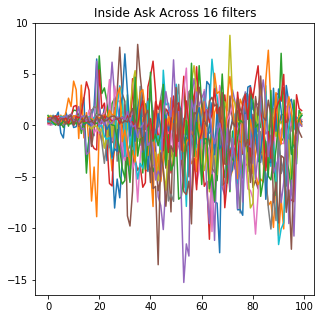

In [35]:
# visualize one layer across all 16 filters
import matplotlib.pylab as plt
%matplotlib inline
plt.figure(figsize=(5,5))
plt.title("Inside Ask Across 16 filters")
for f in kept_filters[:16]:
    img=f[0][:,:,0]
    plt.plot(img[range(0,100)][:,0])

###  Find highest predictions for each category in each batch. Plot highest values

In [36]:
dn, sm, up = [],[],[]

# find the highest scoring input for each categorical output category in each batch
# make our predictions - start from beginning
train_gen=training_generator.GenerateBatch_conv(configs['sequence_length'],configs['batch_size'],configs['nflag'])
for i in range(int(steps_per_epoch)):
    dat=next(train_gen)[0]
    yhat=model.predict(dat)
    #
    dn.append(dat[np.argmax(yhat[:,0])])
    sm.append(dat[np.argmax(yhat[:,1])])
    up.append(dat[np.argmax(yhat[:,2])])
   

In [37]:
dnavg=np.average(np.array(dn),axis=0)
upavg=np.average(np.array(up),axis=0)

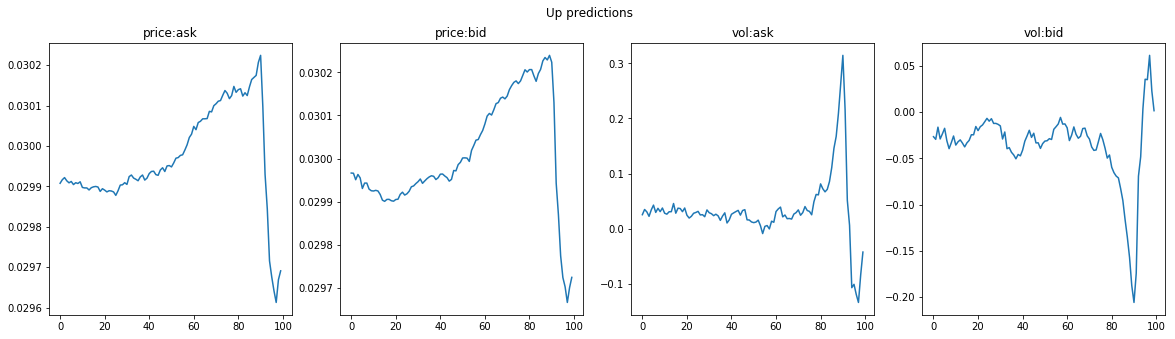

In [38]:
t=np.array([0])
plt.figure(figsize=(20,5))
plt.suptitle("Up predictions")
plt.subplot(1,4,1)
_=plt.plot(upavg[:,t,0])
plt.title('price:ask')
plt.subplot(1,4,2)
_=plt.plot(upavg[:,t+2,0])
plt.title('price:bid')
plt.subplot(1,4,3)
_=plt.plot(upavg[:, t+1,0])
plt.title('vol:ask')
plt.subplot(1,4,4)
_=plt.plot(upavg[:,t+3,0])
_=plt.title('vol:bid')

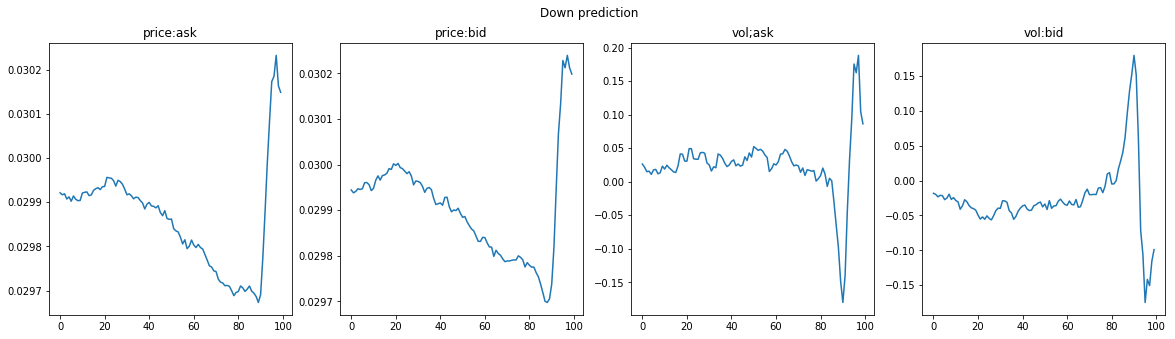

In [39]:
plt.figure(figsize=(20,5))
plt.suptitle("Down prediction")
plt.subplot(1,4,1)
_=plt.plot(dnavg[:,t,0])
plt.title('price:ask')
plt.subplot(1,4,2)
_=plt.plot(dnavg[:,t+2,0])
plt.title('price:bid')
plt.subplot(1,4,3)
_=plt.plot(dnavg[:, t+1,0])
plt.title('vol;ask')
plt.subplot(1,4,4)
_=plt.plot(dnavg[:,t+3,0])
_=plt.title('vol:bid')

### Perform Gradient Ascent on each category (final softmax layer) to generate input with strongest signal.

In [40]:
#visualize
ylabel=[]
layer_name='dense_2' #final layer - categorical
layer_output=layer_dict[layer_name].output
print(layer_output.shape)
for i in range(3):
    print('processing label %d' % i)
    loss=layer_output[:,i] #want to increase value of label i
    #loss=K.mean(layer_output[:,filter_index:,:])
    grads=K.gradients(loss,input_img)[0]
    grads=normalize(grads)
    iterate=K.function([input_img],[loss,grads])
    step=1
    input_img_data=np.random.random((1,100,40,1))
    for j in range(1000):
        loss_value,grad_values=iterate([input_img_data])
        input_img_data +=grad_values*step
        #print('Current loss values:', loss_value)
    print(loss_value)
    ylabel.append((input_img_data[0],loss_value))

(?, 3)
processing label 0
[1.]
processing label 1
[1.3098093e-13]
processing label 2
[1.]


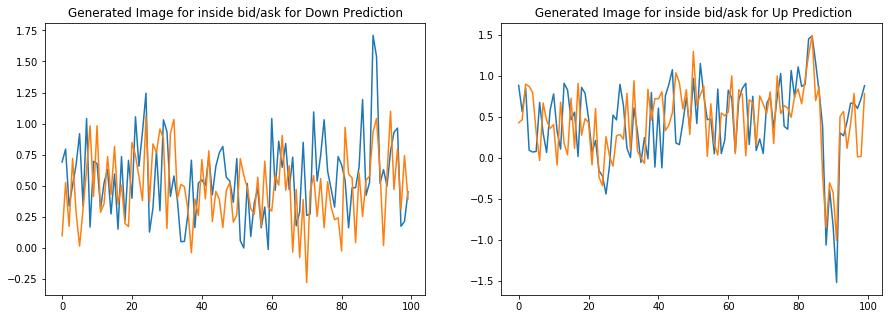

In [41]:

y=ylabel[0][0]

t=np.array([0])
#
y=ylabel[0][0]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Generated Image for inside bid/ask for Down Prediction')
plt.plot(y[:,t,0])
plt.plot(y[:,t+2,0])
#
y=ylabel[2][0]
plt.subplot(1,2,2)
plt.title(' Generated Image for inside bid/ask for Up Prediction')
plt.plot(y[:,t,0])
plt.plot(y[:,t+2,0])
y=ylabel[0][0]